# **Toy Transformer for Time Series Regression**

In this notebook we will build a toy transformer for time series regression on 15min Stock Price data.

#### Library Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

Local imports

In [2]:
# for python scripts use: "os.path.dirname(__file__)" instead of "os.path.abspath('')"
sys.path.append(
    os.path.abspath(os.path.join(os.path.abspath(''), os.path.pardir)))

from data_clean import get_trading_times

### Get the data

Split into train, validation and test sets

In [92]:
data_path = r'..\data\raw\AAPL_15min.csv'
df = pd.read_csv(data_path, index_col=0, 
                 parse_dates=True, infer_datetime_format=True)

# df = get_trading_times(df)
df = df.dropna()

# add days, hours, and minutes to the dataset
dayofweek = df.index.dayofweek
hour = df.index.hour
minute = df.index.minute

# encode the days, hours, and minutes with sin and cos functions
days_in_week = 7
hours_in_day = 24
minutes_in_hour = 60


df['sin_day'] = np.sin(2*np.pi/dayofweek)
df['cos_day'] = np.cos(2*np.pi/dayofweek)
df['sin_hour'] = np.sin(2*np.pi/hour)
df['cos_hour'] = np.cos(2*np.pi/hour)
df['sin_minute'] = np.sin(2*np.pi/minute)
df['cos_minute'] = np.cos(2*np.pi/minute)

df.head()

c:\Users\itber\anaconda3\envs\tf\lib\site-packages\pandas\core\indexes\base.py:920: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\itber\anaconda3\envs\tf\lib\site-packages\pandas\core\indexes\base.py:920: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\itber\anaconda3\envs\tf\lib\site-packages\pandas\core\indexes\base.py:920: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\itber\anaconda3\envs\tf\lib\site-packages\pandas\core\indexes\base.py:920: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


,open,high,low,close,volume,sin_day,cos_day,sin_hour,cos_hour,sin_minute,cos_minute
time,,,,,,,,,,,
2020-10-01 04:15:00,115.318327,115.693796,115.318327,115.614750,21768.0,0.866025,-0.5,1.000000,6.123234e-17,0.406737,0.913545
2020-10-01 04:30:00,115.634512,115.792604,115.407254,115.407254,13550.0,0.866025,-0.5,1.000000,6.123234e-17,0.207912,0.978148
2020-10-01 04:45:00,115.367731,115.367731,115.120712,115.308447,12857.0,0.866025,-0.5,1.000000,6.123234e-17,0.139173,0.990268
2020-10-01 05:00:00,115.308447,115.397374,115.298566,115.318327,10079.0,0.866025,-0.5,0.951057,3.090170e-01,NaN,NaN
2020-10-01 05:15:00,115.417135,115.604869,115.377612,115.604869,3534.0,0.866025,-0.5,0.951057,3.090170e-01,0.406737,0.913545


### Add target columns
We will add a column for price change at each interval, this will be our regression target variable. We will also add another column that quantifys the magnitude of the price change, this will be out target variable for classification.

In [93]:
df['price_diff'] = df['close'].diff()

# thresh = 0.1 # dollars
# df['price_change'] = 1 # price stays the same
# df['price_change'][df['price_diff'] < -thresh] = 0 # downward price movement
# df['price_change'][df['price_diff'] > thresh] = 2 # upward prive movement

In [94]:
df = df.dropna()
df.head()

,open,high,low,close,volume,sin_day,cos_day,sin_hour,cos_hour,sin_minute,cos_minute,price_diff
time,,,,,,,,,,,,
2020-10-01 04:30:00,115.634512,115.792604,115.407254,115.407254,13550.0,0.866025,-0.5,1.000000,6.123234e-17,0.207912,0.978148,-0.207496
2020-10-01 04:45:00,115.367731,115.367731,115.120712,115.308447,12857.0,0.866025,-0.5,1.000000,6.123234e-17,0.139173,0.990268,-0.098808
2020-10-01 05:15:00,115.417135,115.604869,115.377612,115.604869,3534.0,0.866025,-0.5,0.951057,3.090170e-01,0.406737,0.913545,0.286542
2020-10-01 05:30:00,115.604869,115.703677,115.555466,115.703677,7688.0,0.866025,-0.5,0.951057,3.090170e-01,0.207912,0.978148,0.098808
2020-10-01 05:45:00,115.703677,115.851888,115.535704,115.822246,29016.0,0.866025,-0.5,0.951057,3.090170e-01,0.139173,0.990268,0.118569


<AxesSubplot:xlabel='time'>

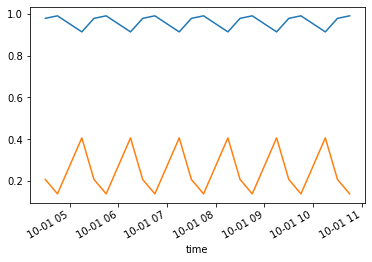

In [100]:
df.cos_minute.iloc[:20].plot()
df.sin_minute.iloc[:20].plot()

### Split into train, valid, and test sets

In [101]:
train_df = df.loc['2020-10-01':'2021-10-01']
valid_df = df.loc['2021-10-02':'2022-05-01']
test_df = df.loc['2022-05-02':]

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(9831, 12)
(5588, 12)
(3886, 12)


### Standardize the Dat

Standardize the data using the train, mean and standard deviation

In [102]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Format Data for Transformer Input

Now we need to format the data for the transformer input. We will use tf.data to generate the dataset, see [example](https://www.tensorflow.org/tutorials/structured_data/time_series) from Tensor Flow tutorial

Probably won't use this :(

In [107]:
def get_window(data, seq_len, tgt_idx):
    ''' Obtains windowed data '''
    
    # feature indexes 
    feat_idxs = np.setdiff1d(np.arange(0, data.shape[1]), tgt_idx)

    x = []
    y = []

    for i in range(len(data) - seq_len):
        window = data.iloc[i:(i+seq_len), feat_idxs]
        target = data.iloc[i+seq_len, tgt_idx]
        
        x.append(window)
        y.append(target)
        
    return np.array(x),np.array(y)

In [126]:
import tensorflow as tf

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, valid_df=valid_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.valid_df = valid_df
      self.test_df = test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
         self.label_columns_indices = {name: i for i, name in
                                       enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                             enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width # sequence length
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])


    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    # WindowGenerator.split_window = split_window


    def plot(self, data, model=None, plot_col='price_diff', max_subplots=3):
        inputs, labels = data
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
          plt.subplot(max_n, 1, n+1)
          plt.ylabel(f'{plot_col} [normed]')
          plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                  label='Inputs', marker='.', zorder=-10)

          if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
          else:
            label_col_index = plot_col_index

          if label_col_index is None:
            continue

          plt.scatter(self.label_indices, labels[n, :, label_col_index],
                      edgecolors='k', label='Labels', c='#2ca02c', s=64)
          if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

          if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

    # WindowGenerator.plot = plot
    
    
    def get_position_encoding(self, n=10000):
        d = self.train_df.shape[1] # assume all features are used
        pos_encode = np.zeros((self.input_width, d))
        for k in range(self.input_width):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                pos_encode[k, 2*i] = np.sin(k/denominator)
                pos_encode[k, 2*i+1] = np.cos(k/denominator)
        return pos_encode

    def make_dataset(self, data, batch_size=32):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=False, #True,
                batch_size=batch_size)

        ds = ds.map(self.split_window)

        return ds

    # WindowGenerator.make_dataset = make_dataset
    

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    # WindowGenerator.train = train
    # WindowGenerator.valid = valid
    # WindowGenerator.test = test
    # WindowGenerator.example = example



In [127]:
WindowGenerator(input_width=10, label_width=1, shift=1, label_columns=['price_diff'])

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['price_diff']

In [128]:
win_gen = WindowGenerator(input_width=10, label_width=1, shift=1, label_columns=['price_diff'])

In [129]:
p = win_gen.get_position_encoding()

In [130]:
p.shape

(10, 12)

In [115]:
example_window = tf.stack([np.array(train_df[:win_gen.total_window_size]),
                           np.array(train_df[100:100+win_gen.total_window_size]),
                           np.array(train_df[200:200+win_gen.total_window_size])])

example_inputs, example_labels = win_gen.split_window(example_window)

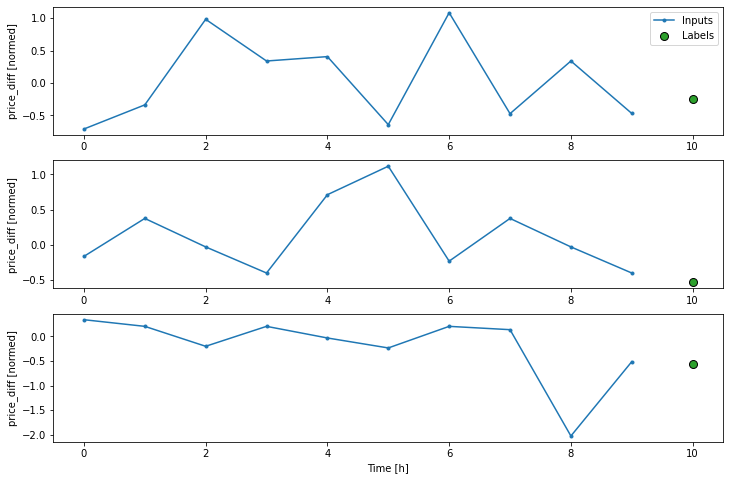

In [116]:
win_gen.plot((example_inputs, example_labels))

The [Dataset.element_spec](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#element_spec) property tells you the structure, data types, and shapes of the dataset elements.

In [117]:
win_gen.train.element_spec

(TensorSpec(shape=(None, 10, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

We can iterate over the dataset and get our batches

In [131]:
for inputs, targets in win_gen.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Targets shape (batch, time, features): {targets.shape}')

Inputs shape (batch, time, features): (32, 10, 12)
Targets shape (batch, time, features): (32, 1, 1)


In [154]:
inputs[0, :, :]

<tf.Tensor: shape=(10, 12), dtype=float32, numpy=
array([[-1.3164947 , -1.3203301 , -1.3185292 , -1.336381  , -0.64998025,
         0.8688863 , -0.50326526,  1.9552284 , -2.8744698 , -0.38321406,
         0.5204014 , -0.70839393],
       [-1.3400742 , -1.3579388 , -1.3438182 , -1.3451144 , -0.65032053,
         0.8688863 , -0.50326526,  1.9552284 , -2.8744698 , -0.98889035,
         0.8801792 , -0.3364252 ],
       [-1.3357077 , -1.3369479 , -1.3211453 , -1.3189142 , -0.65489817,
         0.8688863 , -0.50326526,  1.7269905 , -1.6769598 ,  1.368692  ,
        -1.3972156 ,  0.98237306],
       [-1.3191147 , -1.3282017 , -1.3054488 , -1.3101808 , -0.6528585 ,
         0.8688863 , -0.50326526,  1.7269905 , -1.6769598 , -0.38321406,
         0.5204014 ,  0.33988163],
       [-1.3103815 , -1.3150823 , -1.3071928 , -1.2997007 , -0.6423864 ,
         0.8688863 , -0.50326526,  1.7269905 , -1.6769598 , -0.98889035,
         0.8801792 ,  0.4075123 ],
       [-1.2859288 , -1.2932168 , -1.2845199 

In [150]:
targets[0, :, :]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.2383607]], dtype=float32)>

## **Start Training Models**

First we will need a baseline model to compare our results to. The most simple baseline model will just predict the next value by using the previous value.

In [132]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [133]:
single_step_window = WindowGenerator(
        input_width=1, label_width=1, shift=1,
        label_columns=['price_diff'])


In [134]:
baseline = Baseline(label_index=win_gen.column_indices['price_diff'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.valid)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

175/175 [==============================] - 0s 2ms/step - loss: 4.1929 - mean_absolute_error: 1.2598


### Now let's try a Vanilla Neural Network model

In [135]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])


def compile_and_fit(model, window, lr=1e-4, max_epochs=100, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.valid,
                        callbacks=[early_stopping])
    return history

In [136]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.valid)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
308/308 [==============================] - 4s 7ms/step - loss: 1.0149 - mean_absolute_error: 0.6066 - val_loss: 2.0629 - val_mean_absolute_error: 0.8669
Epoch 2/100
308/308 [==============================] - 2s 7ms/step - loss: 1.0004 - mean_absolute_error: 0.5969 - val_loss: 2.0588 - val_mean_absolute_error: 0.8664
Epoch 3/100
308/308 [==============================] - 2s 7ms/step - loss: 0.9962 - mean_absolute_error: 0.5949 - val_loss: 2.0590 - val_mean_absolute_error: 0.8670
Epoch 4/100
175/175 [==============================] - 1s 3ms/step - loss: 2.0593 - mean_absolute_error: 0.8672


Now let's build the transformer

In [137]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [138]:
def build_model(
            input_shape,
            head_size,
            num_heads,
            ff_dim,
            num_transformer_blocks,
            mlp_units,
            dropout=0,
            mlp_dropout=0,
        ):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [148]:
inputs.shape

TensorShape([32, 10, 12])

In [144]:
input_shape = inputs.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=256,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

# model.compile(
#     loss="mean_squared_error",
#     optimizer=keras.optimizers.Adam(learning_rate=1e-4)
# )
# #model.summary()

# callbacks = [keras.callbacks.EarlyStopping(patience=10, \
#     restore_best_weights=True)]


In [145]:
compile_and_fit(model, win_gen, lr=1e-4, max_epochs=200, patience=5)

Epoch 1/200
307/307 [==============================] - 13s 35ms/step - loss: 1.0058 - mean_absolute_error: 0.5984 - val_loss: 2.0529 - val_mean_absolute_error: 0.8608
Epoch 2/200
307/307 [==============================] - 10s 33ms/step - loss: 1.0070 - mean_absolute_error: 0.5977 - val_loss: 2.0493 - val_mean_absolute_error: 0.8606
Epoch 3/200
307/307 [==============================] - 10s 33ms/step - loss: 1.0041 - mean_absolute_error: 0.5968 - val_loss: 2.0484 - val_mean_absolute_error: 0.8605
Epoch 4/200
307/307 [==============================] - 10s 33ms/step - loss: 1.0030 - mean_absolute_error: 0.5966 - val_loss: 2.0483 - val_mean_absolute_error: 0.8608
Epoch 5/200
307/307 [==============================] - 10s 33ms/step - loss: 1.0044 - mean_absolute_error: 0.5968 - val_loss: 2.0498 - val_mean_absolute_error: 0.8609
Epoch 6/200
307/307 [==============================] - 10s 33ms/step - loss: 1.0053 - mean_absolute_error: 0.5969 - val_loss: 2.0493 - val_mean_absolute_error: 0.862

In [146]:
val_performance['xform_1'] = model.evaluate(win_gen.valid)
performance['xfborm_1'] = model.evaluate(win_gen.test, verbose=0)

175/175 [==============================] - 2s 13ms/step - loss: 2.0486 - mean_absolute_error: 0.8601


In [147]:
val_performance

{'Baseline': [4.192903995513916, 1.259775996208191],
 'Dense': [2.059305191040039, 0.8672387003898621],
 'xform_0': [2.048050880432129, 0.8603833317756653],
 'xform_1': [2.0485799312591553, 0.8600624203681946]}